1) Setup & Import Library

In [1]:
import os
import sys
import numpy as np
import pandas as pd

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

print("Versi pandas:", pd.__version__)

Versi pandas: 2.2.2


2) Ambil Data dari Google Drive

In [5]:
from pathlib import Path
folder_url = "https://drive.google.com/drive/folders/1c19XLOqgx5vmWAAcbO92zFC_sy556BGb"
out_dir = Path("data")
out_dir.mkdir(exist_ok=True)
!gdown --folder {folder_url} -O {out_dir}

# Cek file yang terunduh
list(out_dir.glob("*"))

# Ganti sesuai nama file yang benar di folder tersebut:
FILE_PATH = "/content/data/Salinan Online Retail Data.csv"   # <-- ubah ke nama file yang ada (csv/xlsx/parquet)

Retrieving folder contents
Processing file 1gP4DPGt_KIDNqfA9J3vAbYg4W_KgOMfV Modul 7 - Use Case - User Retention Analysis.ipynb
Processing file 1iVi5k9OJ2xobQTglVNQ5vExqBcF27cF0 Salinan Online Retail Data.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1gP4DPGt_KIDNqfA9J3vAbYg4W_KgOMfV
To: /content/data/Modul 7 - Use Case - User Retention Analysis.ipynb
100% 148k/148k [00:00<00:00, 59.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iVi5k9OJ2xobQTglVNQ5vExqBcF27cF0
To: /content/data/Salinan Online Retail Data.csv
100% 34.1M/34.1M [00:00<00:00, 186MB/s]
Download completed


3) Load Data + Pemeriksaan Awal

In [6]:
# Deteksi otomatis berdasarkan ekstensi
def load_any(FILE_PATH: str) -> pd.DataFrame:
    ext = os.path.splitext(FILE_PATH)[1].lower()
    if ext == ".csv":
        df = pd.read_csv(FILE_PATH)
    elif ext in (".xlsx", ".xls"):
        df = pd.read_excel(FILE_PATH)
    elif ext == ".parquet":
        df = pd.read_parquet(FILE_PATH)
    else:
        raise ValueError(f"Ekstensi file {ext} belum didukung. Gunakan csv/xlsx/parquet.")
    return df

# ==== SET di sini ====
# FILE_PATH = "data/orders.csv"  # pastikan sudah di-set dari salah satu opsi di atas

df_raw = load_any(FILE_PATH)
print(df_raw.shape)
df_raw.head()

(461773, 7)


,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [8]:
# Info kolom & tipe data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


In [9]:
# Cek missing per kolom
df_raw.isna().mean().sort_values(ascending=False)

,0
customer_id,0.218549
product_name,0.005886
order_id,0.000000
product_code,0.000000
quantity,0.000000
order_date,0.000000
price,0.000000


4) Data Cleaning Minimum (tanggal & customer)

In [10]:
df = df_raw.copy()

# 4.1 Parse tanggal
df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

# 4.2 Buat kolom revenue (opsional tetapi penting untuk cohort revenue)
df["revenue"] = df["price"] * df["quantity"]

# 4.3 Bersihkan customer_id
#    - Banyak dataset transaksi menyimpan id pelanggan sebagai float (mis. 123.0).
#    - Kita ubah ke string/int yang stabil, dan buang yang NA.
df = df[~df["customer_id"].isna()].copy()

# Ubah float -> int kalau memang bilangan bulat, kemudian ke string
# Jika ada yang bukan bilangan bulat, langsung cast ke string aman.
if np.all(np.modf(df["customer_id"].values)[0] == 0):  # semua ".0"
    df["customer_id"] = df["customer_id"].astype("int64").astype("string")
else:
    df["customer_id"] = df["customer_id"].astype("string")

# 4.4 Buang baris dengan tanggal gagal parse
df = df[~df["order_date"].isna()].copy()

print("Ukuran data setelah cleaning:", df.shape)
df[["order_id","customer_id","order_date","quantity","price","revenue"]].head()

Ukuran data setelah cleaning: (360853, 8)


,order_id,customer_id,order_date,quantity,price,revenue
0,493410,12346,2010-01-04 09:24:00,5,4.50,22.50
1,C493411,14590,2010-01-04 09:43:00,-1,4.25,-4.25
2,493412,12346,2010-01-04 09:53:00,5,4.50,22.50
6,493414,14590,2010-01-04 10:28:00,36,2.55,91.80
7,493414,14590,2010-01-04 10:28:00,12,4.25,51.00


5) Normalisasi ke Level Order (hindari double-count karena baris per item)

In [11]:
# Ambil satu baris unik per order untuk menghitung aktif/belum aktif pelanggan.
# Untuk revenue analisis, kita juga siapkan agregasi revenue per order.
order_level = (
    df
    .groupby(["order_id", "customer_id", pd.Grouper(key="order_date", freq="D")], as_index=False)
    .agg(
        order_revenue=("revenue", "sum"),
        order_qty=("quantity", "sum")
    )
)

print(order_level.shape)
order_level.head()

(20447, 5)


,order_id,customer_id,order_date,order_revenue,order_qty
0,493410,12346,2010-01-04,22.50,5
1,493412,12346,2010-01-04,22.50,5
2,493414,14590,2010-01-04,290.20,88
3,493427,13287,2010-01-04,264.38,122
4,493428,16550,2010-01-04,230.90,84


6) Definisikan Bulan Transaksi & Bulan Cohort (bulan pertama pelanggan bertransaksi)

In [12]:
# 6.1 Bulan transaksi (periode bulanan)
order_level["order_month"] = order_level["order_date"].values.astype("datetime64[M]")

# 6.2 Tentukan bulan pertama (cohort) per customer
first_purchase = (
    order_level
    .groupby("customer_id", as_index=False)["order_month"].min()
    .rename(columns={"order_month": "cohort_month"})
)

# Gabungkan kembali
order_level = order_level.merge(first_purchase, on="customer_id", how="left")
order_level[["customer_id","order_date","order_month","cohort_month"]].head()

,customer_id,order_date,order_month,cohort_month
0,12346,2010-01-04,2010-01-01,2010-01-01
1,12346,2010-01-04,2010-01-01,2010-01-01
2,14590,2010-01-04,2010-01-01,2010-01-01
3,13287,2010-01-04,2010-01-01,2010-01-01
4,16550,2010-01-04,2010-01-01,2010-01-01


7) Hitung Cohort Index (berapa bulan sejak pembelian pertama)

In [13]:
# Fungsi menghitung selisih bulan (order_month - cohort_month) + 1
def month_diff(d1: pd.Series, d2: pd.Series) -> pd.Series:
    return (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month) + 1

order_level["cohort_index"] = month_diff(order_level["order_month"], order_level["cohort_month"])
order_level["cohort_index"] = order_level["cohort_index"].astype(int)

order_level[["customer_id","cohort_month","order_month","cohort_index"]].head(10)

,customer_id,cohort_month,order_month,cohort_index
0,12346,2010-01-01,2010-01-01,1
1,12346,2010-01-01,2010-01-01,1
2,14590,2010-01-01,2010-01-01,1
3,13287,2010-01-01,2010-01-01,1
4,16550,2010-01-01,2010-01-01,1
5,14680,2010-01-01,2010-01-01,1
6,14709,2010-01-01,2010-01-01,1
7,13798,2010-01-01,2010-01-01,1
8,13206,2010-01-01,2010-01-01,1
9,13694,2010-01-01,2010-01-01,1


8) Matriks Retention (Active Customers per Cohort vs Cohort Index)

In [14]:
# 8.1 Hitung jumlah customer aktif unik per (cohort_month, cohort_index)
cohort_counts = (
    order_level
    .groupby(["cohort_month","cohort_index"])["customer_id"]
    .nunique()
    .reset_index(name="active_customers")
)

# 8.2 Ukuran cohort (jumlah customer unik di bulan cohort_index=1)
cohort_size = (
    cohort_counts[cohort_counts["cohort_index"] == 1]
    .loc[:, ["cohort_month","active_customers"]]
    .rename(columns={"active_customers":"cohort_size"})
)

# 8.3 Gabungkan ukuran cohort agar bisa hitung retention rate
cohort_counts = cohort_counts.merge(cohort_size, on="cohort_month", how="left")
cohort_counts["retention_rate"] = cohort_counts["active_customers"] / cohort_counts["cohort_size"]

# 8.4 Pivot jadi matriks
retention_matrix = cohort_counts.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="retention_rate"
).sort_index()

# 8.5 (Opsional) Matriks jumlah aktif
active_matrix = cohort_counts.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="active_customers"
).sort_index()

retention_matrix.head(), active_matrix.head()

(cohort_index   1         2         3         4         5         6         7         8         9         10        11        12
 cohort_month                                                                                                                   
 2010-01-01    1.0  0.394993  0.470097  0.443672  0.431154  0.431154  0.411683  0.379694  0.406120  0.460362  0.474270  0.353268
 2010-02-01    1.0  0.334052  0.275862  0.355603  0.327586  0.265086  0.260776  0.346983  0.334052  0.362069  0.217672       NaN
 2010-03-01    1.0  0.270370  0.296296  0.270370  0.259259  0.231481  0.277778  0.350000  0.361111  0.183333       NaN       NaN
 2010-04-01    1.0  0.246246  0.228228  0.189189  0.213213  0.240240  0.297297  0.306306  0.153153       NaN       NaN       NaN
 2010-05-01    1.0  0.203636  0.181818  0.192727  0.185455  0.265455  0.240000  0.156364       NaN       NaN       NaN       NaN,
 cohort_index     1      2      3      4      5      6      7      8      9      10     11     1

9) Cohort Revenue

In [15]:
# 9.1 Revenue per (cohort_month, cohort_index)
rev_cohort = (
    order_level
    .groupby(["cohort_month","cohort_index"])["order_revenue"]
    .sum()
    .reset_index()
    .rename(columns={"order_revenue":"revenue"})
)

# 9.2 Pivot revenue matrix
revenue_matrix = rev_cohort.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="revenue",
    aggfunc="sum"
).sort_index()

revenue_matrix.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2010-01-01,399196.632,203380.743,281447.19,238457.731,206139.14,218265.91,246412.920,239475.04,237929.051,292326.850,375349.55,255780.07
2010-02-01,199433.193,53559.160,62113.75,80079.210,69607.38,59554.67,55218.540,84515.29,82922.770,97241.151,52358.45,NaN
2010-03-01,214211.481,66884.830,61445.41,69124.800,56463.81,67973.19,86407.330,123115.88,137966.790,40039.020,NaN,NaN
2010-04-01,105488.280,18812.810,26026.53,32796.760,27810.57,33941.06,41449.760,40763.21,19090.100,NaN,NaN,NaN
2010-05-01,99575.610,17042.140,16176.09,13071.360,16890.87,28620.98,27456.771,12834.90,NaN,NaN,NaN,NaN


10) Visualisasi Heatmap

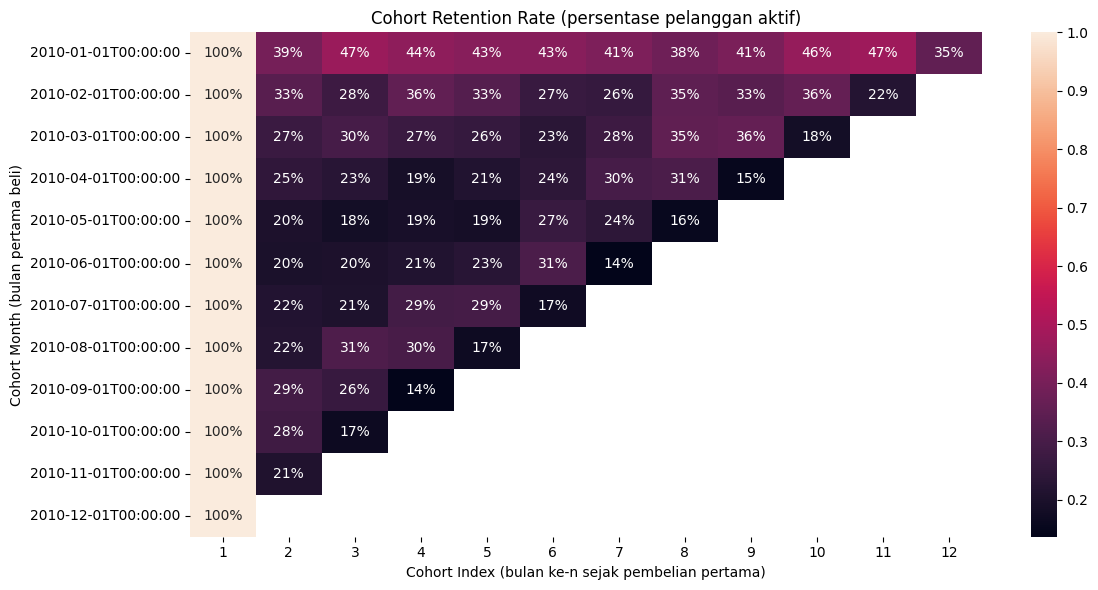

In [16]:
# Agar skala 0..1 rapi
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cbar=True)
plt.title("Cohort Retention Rate (persentase pelanggan aktif)")
plt.ylabel("Cohort Month (bulan pertama beli)")
plt.xlabel("Cohort Index (bulan ke-n sejak pembelian pertama)")
plt.tight_layout()
plt.show()

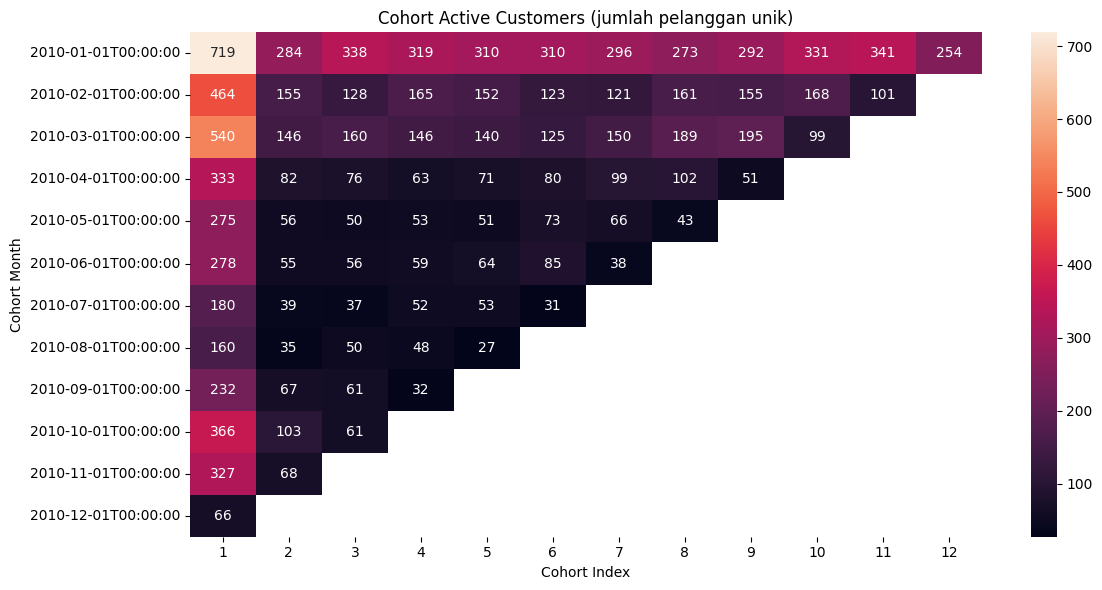

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(active_matrix, annot=True, fmt=".0f", cbar=True)
plt.title("Cohort Active Customers (jumlah pelanggan unik)")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index")
plt.tight_layout()
plt.show()

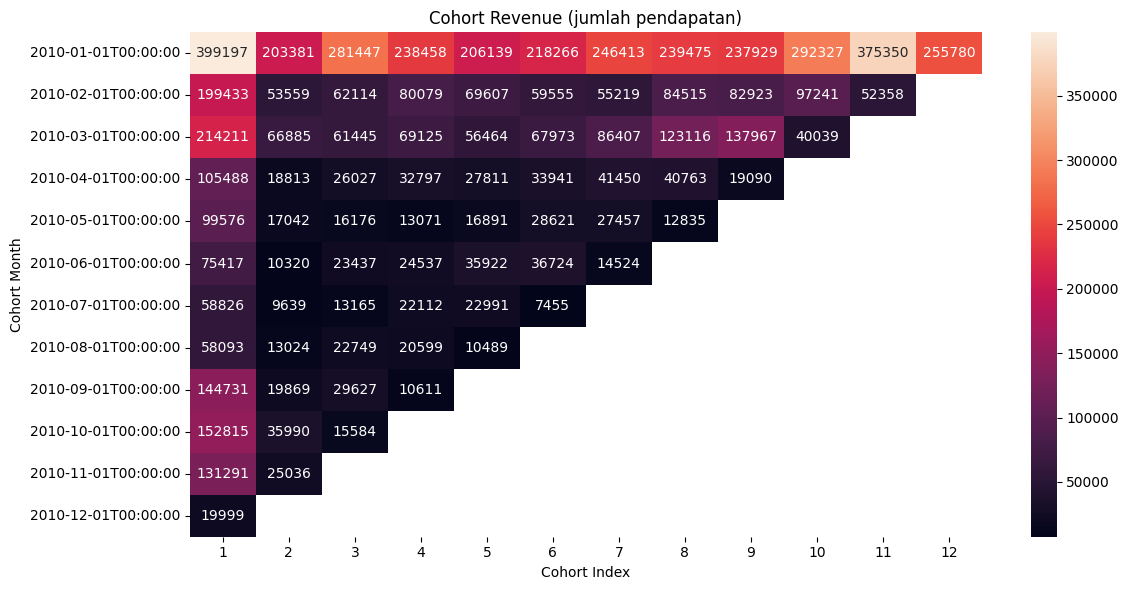

In [18]:
plt.figure(figsize=(12, 6))
sns.heatmap(revenue_matrix, annot=True, fmt=".0f", cbar=True)
plt.title("Cohort Revenue (jumlah pendapatan)")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index")
plt.tight_layout()
plt.show()


11) Ringkasan & Ekspor Hasil

In [19]:
# Ringkasan ukuran cohort
cohort_size.sort_values("cohort_month").head(10)

,cohort_month,cohort_size
0,2010-01-01,719
12,2010-02-01,464
23,2010-03-01,540
33,2010-04-01,333
42,2010-05-01,275
50,2010-06-01,278
57,2010-07-01,180
63,2010-08-01,160
68,2010-09-01,232
72,2010-10-01,366


In [20]:
# Simpan matriks ke file (opsional)
out_dir = "cohort_outputs"
os.makedirs(out_dir, exist_ok=True)

retention_matrix.to_csv(os.path.join(out_dir, "retention_matrix.csv"))
active_matrix.to_csv(os.path.join(out_dir, "active_customers_matrix.csv"))
revenue_matrix.to_csv(os.path.join(out_dir, "revenue_matrix.csv"))

cohort_counts.to_csv(os.path.join(out_dir, "cohort_counts_longformat.csv"), index=False)
print("File tersimpan di folder:", out_dir)


File tersimpan di folder: cohort_outputs
